<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/Sadat/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Set a consistent random seed at the beginning of your notebook
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Define dataset path and categories (replace with your actual paths and categories)
dataset_path = "/content/drive/MyDrive/project_445/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 64


Preprocessing

In [30]:
# Cell 2: Data Loading and Preprocessing with Augmentation
import os
import cv2
import numpy as np
import random

# Set random seed for reproducibility
random.seed(random_seed)  # e.g., random_seed = 42

# Define augmentation function
def augment_image(img):
    """Augment with controlled rotation, brightness, and noise"""
    # Rotation (reduced to avoid excessive tilt)
    angle = random.uniform(-10, 10)  # Back to ±10°
    M = cv2.getRotationMatrix2D((IMG_SIZE / 2, IMG_SIZE / 2), angle, 1)
    img = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE), borderMode=cv2.BORDER_REFLECT_101)

    # Brightness adjustment (narrower range)
    brightness = random.uniform(0.8, 1.2)  # ±20%
    img = np.clip(img * brightness, 0, 1).astype(np.float32)

    # Noise (reduced intensity)
    noise = np.random.normal(0, 0.03, img.shape).astype(np.float32)  # Lower sigma
    img = np.clip(img + noise, 0, 1).astype(np.float32)

    return img

# Initialize empty lists
data = []
labels = []
original_images = []

# Load and preprocess images
for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_original = cv2.imread(img_path)
        if img_original is None:
            print(f"Warning: Failed to load {img_path}")
            continue
        original_images.append(img_original)
        img = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        # Original image
        data.append(img)
        labels.append(label)

        # Augmented image
        img_augmented = augment_image(img)
        data.append(img_augmented)
        labels.append(label)

# Convert to numpy arrays
X = np.array(data)  # Shape: (n_samples, IMG_SIZE, IMG_SIZE, 3)
y = np.array(labels)  # Shape: (n_samples,)

print("Dataset loaded and preprocessed with refined augmentation (rotation, brightness, noise).")
print("X shape:", X.shape)
print("y shape:", y.shape)

Dataset loaded and preprocessed with refined augmentation (rotation, brightness, noise).
X shape: (200, 64, 64, 3)
y shape: (200,)


Preprossed




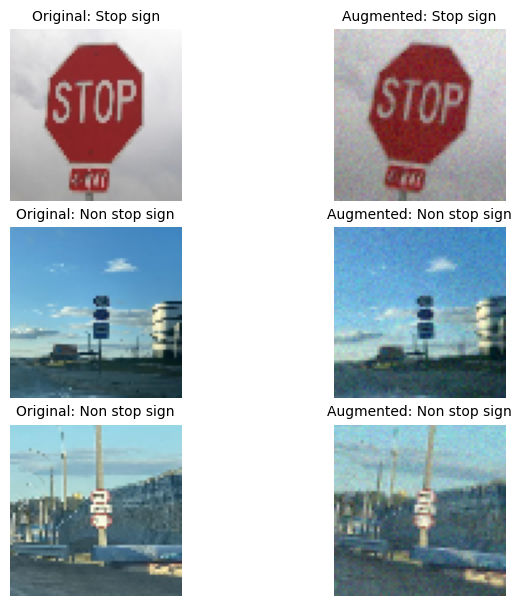

In [31]:
# Cell: Display Preprocessed Images
import matplotlib.pyplot as plt
import numpy as np

# Number of image pairs to display (original + augmented)
num_pairs = 3  # Reduced for compactness, adjust as needed

# Select indices for original images (even indices: 0, 2, 4, ...)
original_indices = np.random.choice(range(0, len(X), 2), num_pairs, replace=False)

# Set up the plot with smaller figure size
plt.figure(figsize=(8, num_pairs * 2))  # Smaller width (8) and height (2 per pair)

for i, orig_idx in enumerate(original_indices):
    # Original image
    orig_img = X[orig_idx]
    orig_label = categories[y[orig_idx]]

    # Augmented image
    aug_img = X[orig_idx + 1]
    aug_label = categories[y[orig_idx + 1]]

    # Plot original image
    plt.subplot(num_pairs, 2, i * 2 + 1)
    plt.imshow(orig_img)
    plt.title(f"Original: {orig_label}", fontsize=10)  # Smaller font
    plt.axis('off')

    # Plot augmented image
    plt.subplot(num_pairs, 2, i * 2 + 2)
    plt.imshow(aug_img)
    plt.title(f"Augmented: {aug_label}", fontsize=10)  # Smaller font
    plt.axis('off')

plt.tight_layout(pad=0.5)  # Reduced padding for compact display
plt.show()

Split the Dataset into Training, Validation, and Test Sets

In [32]:
# Cell 3: Data Splitting
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify=y_temp)

# Verify all splits
print("\nTraining set:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nValidation set:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\nTest set:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

assert X_train.shape[0] == y_train.shape[0], "Training set mismatch!"
assert X_val.shape[0] == y_val.shape[0], "Validation set mismatch!"
assert X_test.shape[0] == y_test.shape[0], "Test set mismatch!"

print("\nData split into training, validation, and test sets.")


Training set:
X_train shape: (120, 64, 64, 3)
y_train shape: (120,)

Validation set:
X_val shape: (40, 64, 64, 3)
y_val shape: (40,)

Test set:
X_test shape: (40, 64, 64, 3)
y_test shape: (40,)

Data split into training, validation, and test sets.


CNN model Training

In [48]:
# Cell 5: Model Training (CNN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random

tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

num_classes = len(categories)

# Convert to tensors upfront to avoid retracing
y_train_onehot = tf.convert_to_tensor(tf.keras.utils.to_categorical(y_train, num_classes))
y_val_onehot = tf.convert_to_tensor(tf.keras.utils.to_categorical(y_val, num_classes))
y_test_onehot = tf.convert_to_tensor(tf.keras.utils.to_categorical(y_test, num_classes))

model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=100,
    batch_size=16,  # Smaller batch size to use full dataset
    callbacks=[early_stopping],
    verbose=1,
    shuffle=True  # Re-enabled for better generalization
)

model.save('cnn_model.keras')
print("CNN model trained and saved as 'cnn_model.keras'.")
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.4646 - loss: 2.8889 - val_accuracy: 0.7250 - val_loss: 1.9482
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6700 - loss: 1.7566 - val_accuracy: 0.7250 - val_loss: 1.2112
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7158 - loss: 1.2052 - val_accuracy: 0.9500 - val_loss: 0.6678
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8007 - loss: 0.7435 - val_accuracy: 0.9750 - val_loss: 0.4753
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8831 - loss: 0.5524 - val_accuracy: 1.0000 - val_loss: 0.2856
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8977 - loss: 0.4388 - val_accuracy: 1.0000 - val_loss: 0.2251
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9011 - loss: 0.3858 - val_accuracy: 0.9750 - val_loss: 0.2510
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9256 - loss: 0.2962 - val_accuracy: 1.0000 - v

Test Set

In [49]:
# Cell 6: Model Testing
import tensorflow as tf
import numpy as np

# Load the trained model from Cell 5
model = tf.keras.models.load_model('cnn_model.keras')

# Evaluate on test set using X_test and y_test_onehot from Cell 5
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

# Predict on test set for use in visualization (Cell 7)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Print results
print("\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

Test Set Evaluation:
Test Loss: 0.2745
Test Accuracy: 0.9250


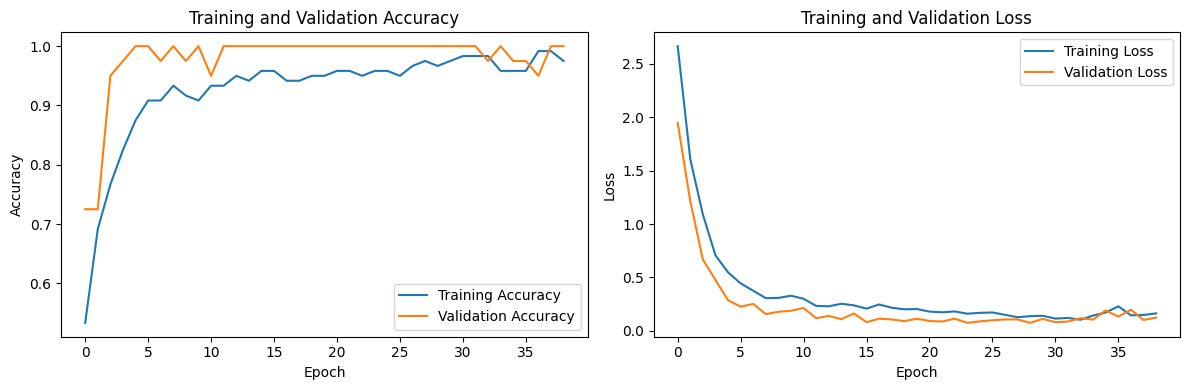

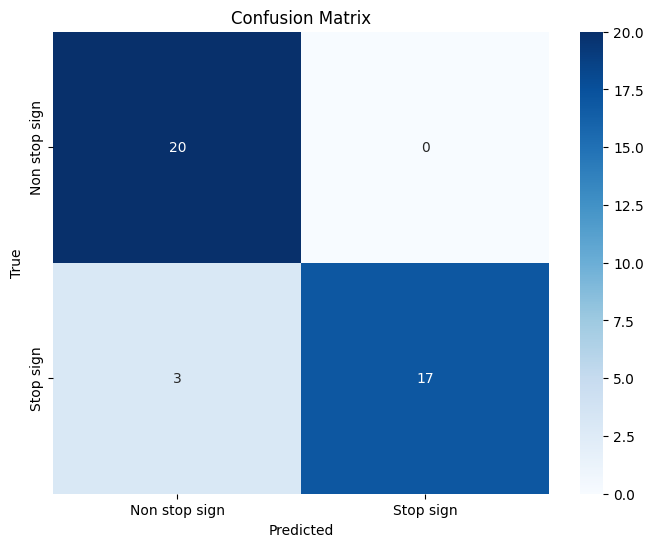


Classification Report:
               precision    recall  f1-score   support

Non stop sign       0.87      1.00      0.93        20
    Stop sign       1.00      0.85      0.92        20

     accuracy                           0.93        40
    macro avg       0.93      0.93      0.92        40
 weighted avg       0.93      0.93      0.92        40



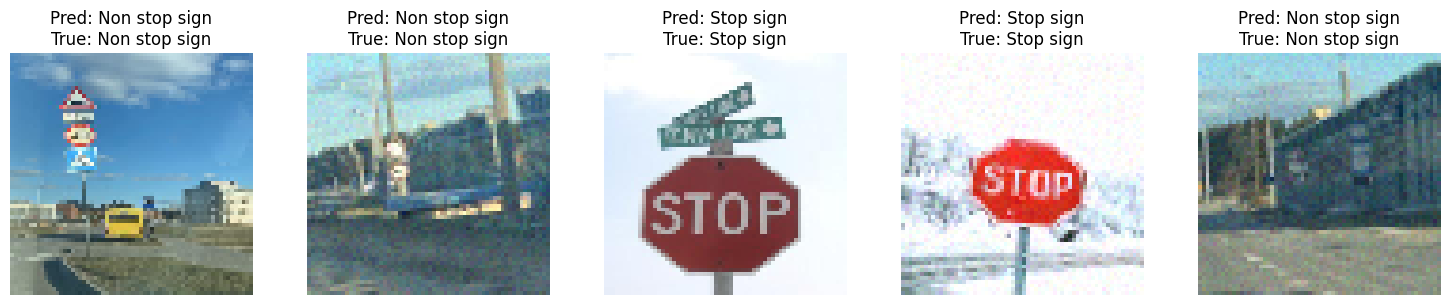

In [50]:
# Cell 7: Output and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=categories))

# Display some example predictions
num_examples = 5
indices = np.random.choice(len(X_test), num_examples, replace=False)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Pred: {categories[y_pred_classes[idx]]}\nTrue: {categories[y_test_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()